This Project strives to predict housing price with various features about housing conditions such as areas and conditions of each part of the house. Lots of features were generated and modifies in the data preprocessing to facilitate modelling process afterward. Two models ElasticNet and XgBoost were combined after testing each one alone to achieve better overall performance in the prediction of testing set.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, clone
from CategoricalEncoder import CategoricalEncoder
from scipy.special import boxcox1p
from scipy.stats import rankdata
from itertools import combinations
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

train = pd.read_csv('Data/train.csv')
sub_test = pd.read_csv('Data/test.csv')

In [2]:
train.info()
#found a few numerical and categorical features with missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [3]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Text(0.5,1,'SalePrice Distribution')

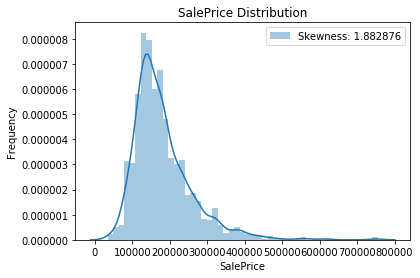

In [4]:
sns.distplot(train['SalePrice'], label = 'Skewness: %f' % (train['SalePrice'].skew()))
plt.legend(loc='best')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')
#the saleprice does not resemble a normal distribution, so for linear models, it should be transfromed thorugh log or sqrt
#function

In [5]:
def cat_to_num(data):
    #encode majority values in categorical features
    data['IsLotShapeRegular'] = (data['LotShape'] == 'Reg').astype(int)
    data['IsLandLevel'] = (data['LandContour'] == 'Lvl').astype(int)
    data['IsLandSlopeGentle'] = (data['LandSlope'] == 'Gtl').astype(int)
    data['IsElectricalSBrkr'] = (data['Electrical'] == 'SBrkR').astype(int)
    data['IsGarageDetached'] = (data['GarageType'] == 'Detchd').astype(int)
    data['IsPavedDrive'] = (data['PavedDrive'] == 'Y').astype(int)
    
    #encode quality that may affect housing prices
    data['HasShed'] = (data['MiscFeature'] == 'Shed').astype(int)
    data["Has2ndFloor"] = (data["2ndFlrSF"] == 0).astype(int)
    data["HasMasVnr"] = (data["MasVnrArea"] == 0).astype(int)
    data["HasWoodDeck"] = (data["WoodDeckSF"] == 0).astype(int)
    data["HasOpenPorch"] = (data["OpenPorchSF"] == 0).astype(int)
    data["HasEnclosedPorch"] = (data["EnclosedPorch"] == 0).astype(int)
    data["Has3SsnPorch"] = (data["3SsnPorch"] == 0).astype(int)
    data["HasScreenPorch"] = (data["ScreenPorch"] == 0).astype(int)
    data['HasRemodel'] = (data['YearRemodAdd'] == data['YearBuilt']).astype(int)
    data['IsRecentModel'] = (data['YearRemodAdd'] == data['YrSold']).astype(int)
    data['IsNew'] = (data['YearBuilt'] == data['YrSold']).astype(int)
    data.loc[data['Neighborhood'].isin(['NridgHt', 'Crawfor', 'StoneBr', 'Somerst', 'NoRidge']), 'GoodNeighborhood'] = 1
    data['GoodNeighborhood'].fillna(0, inplace=True)
    NeighborhoodPriceIndex = (data.groupby('Neighborhood')['SalePrice'].median()/100000).apply(np.ceil)
    data['NeighborhoodPriceIndex'] = data['Neighborhood'].replace(NeighborhoodPriceIndex)
    
    #convert some numerical features to categorical
    data['YrSold'] = data['YrSold'].astype('object')
    data['MoSold'] = data['MoSold'].astype('object')
    data['MSSubClass'] = data['MSSubClass'].astype('object')
    
    #fill missing values according to data description
    data.drop(['Id', 'Condition2', 'Utilities'], axis = 1, inplace=True)
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MiscFeature', \
               'PoolQC', 'Alley', 'Fence', 'FireplaceQu', 'BsmtQual', 'BsmtCond', 'BsmtExposure',\
                'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
        data[col].fillna('None', inplace=True)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',\
               'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'):
        data[col].fillna(0, inplace=True)
        
    #convert textual evaluations such as bad and good into numerical values
    data['LotShape'] = data['LotShape'].map({'Reg': 0, 'IR0.5': 0.5, 'IR2': 1, 'IR3': 1.5})
    data['LandSlope'] =data['LandSlope'].map({'Gtl': 0, 'Mod': 0.5, 'Sev': 1})
    data['ExterQual'] = data['ExterQual'].map({'Po': 0, 'Fa': 0.5, 'TA': 1, 'Gd': 1.5, 'Ex': 2})
    data['ExterCond'] = data['ExterCond'].map({'Po': 0, 'Fa': 0.5, 'TA': 1, 'Gd': 1.5, 'Ex': 2})
    data['BsmtQual'] = data['BsmtQual'].map({'None': 0, 'Po': 0.5, 'Fa': 1, 'TA': 1.5, 'Gd': 2, 'Ex': 2.5})
    data['BsmtCond'] = data['BsmtCond'].map({'None': 0, 'Po': 0.5, 'Fa': 1, 'TA': 1.5, 'Gd': 2, 'Ex': 2.5})
    data['BsmtExposure'] = data['BsmtExposure'].map({'None': 0, 'No': 0.5, 'Mn': 1, 'Av': 1.5, 'Gd': 2})
    data['BsmtFinType1'] = data['BsmtFinType1'].map({'None': 0, 'Unf': 0.5, 'LwQ': 1, 'Rec': 1.5, 'BLQ': 2, 'ALQ': 2.5, 'GLQ': 3})
    data['BsmtFinType2'] = data['BsmtFinType2'].map({'None': 0, 'Unf': 0.5, 'LwQ': 1, 'Rec': 1.5, 'BLQ': 2, 'ALQ': 2.5, 'GLQ': 3})
    data['HeatingQC'] = data['HeatingQC'].map({'Po': 0, 'Fa': 0.5, 'TA': 1, 'Gd': 1.5, 'Ex': 2})
    data['KitchenQual'] = data['KitchenQual'].map({'Po': 0, 'Fa': 0.5, 'TA': 1, 'Gd': 1.5, 'Ex': 2})
    data['FireplaceQu'] = data['FireplaceQu'].map({'None': 0, 'Po': 0.5, 'Fa': 1, 'TA': 1.5, 'Gd': 2, 'Ex': 2.5})
    data['GarageFinish'] = data['GarageFinish'].map({'None': 0, 'Unf': 0.5, 'RFn': 1, 'Fin': 1.5})
    data['GarageQual'] = data['GarageQual'].map({'None': 0, 'Po': 0.5, 'Fa': 1, 'TA': 1.5, 'Gd': 2, 'Ex': 2.5})
    data['GarageCond'] = data['GarageCond'].map({'None': 0, 'Po': 0.5, 'Fa': 1, 'TA': 1.5, 'Gd': 2, 'Ex': 2.5})
    data['PavedDrive'] = data['PavedDrive'].map({'N': 0, 'P': 0.5, 'Y': 1})
    data['PoolQC'] = data['PoolQC'].map({'Fa': 1, 'TA': 1.5, 'Gd': 2, 'Ex': 2.5})
    data['Fence'] = data['Fence'].map({'None': 0, 'MnWw': 0.5, 'GdWo': 1, 'MnPrv': 1.5, 'GdPrv': 2})
    data["Functional"].fillna('Typ', inplace=True)
    data["Functional"] = data["Functional"].map(
        {"Sal": 0, "Sev": 0.5, "Maj2": 1, "Maj0.5": 1.5, 
         "Mod": 2, "Min2": 2.5, "Min0.5": 3, "Typ": 3.5})
    data['ResidentZone'] = data['MSZoning'].map({'A': 0, 'C': 0, 'FV': 0.5, 'I': 0, 'RH': 2, 'RL': 0.5, 'RP': 1, 'RM': 1})
    
    #replace rare values with majorities to avoid problems in train/test split
    data['RoofMatl'].replace(to_replace = ['Roll', 'Metal', 'Membran'], value = 'CompShg', inplace=True)
    data['Exterior1st'].replace(to_replace = ['Stone', 'BrkComm', 'CBlock', 'AsphShn', 'ImStucc'\
                                             ], value = 'CompShg', inplace=True)
    data['Exterior2nd'].replace(to_replace = ['Other', 'Stone', 'CBlock', 'AsphShn',\
                                             ], value = 'VinylSd', inplace=True)
    data['Heating'].replace(to_replace = ['Floor', 'OthW', 'Wall'\
                                             ], value = 'GasA', inplace=True)
    data['MiscFeature'].replace(to_replace = ['TenC', 'Othr', 'Gar2'\
                                             ], value = 'None', inplace=True)
    data['ExterCond'].replace(to_replace = ['Po', 'Ex'\
                                             ], value = 'TA', inplace=True)  
    data['Foundation'].replace(to_replace = ['Wood', 'Stone'\
                                             ], value = 'PConc', inplace=True) 
    data['SaleType'].replace(to_replace = ['Con', 'Oth', 'CWD', 'ConLI', 'ConLw'\
                                             ], value = 'WD', inplace=True) 
    data['Electrical'].replace(to_replace = ['Mix', 'FuseP'], value = 'SBrkr', inplace=True) 
    
    #process some numerical features by the way
    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    data['AllArea'] = data[area_cols].sum(axis = 1)
    data['YearSinceRemodel'] = data['YrSold'] - data['YearRemodAdd']
    return data

train = cat_to_num(train)

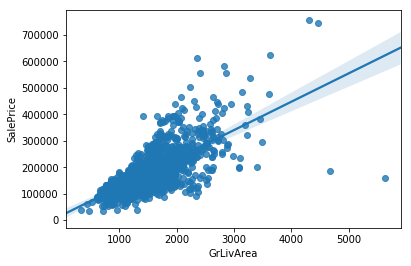

In [15]:
sns.regplot(x = train['GrLivArea'], y = train['SalePrice'])
# the plot below shows linear relationship bettween GrLivArea and SalePrice, but there are 
# some extreme outliers in the region where GrLivArea > 4000 

In [5]:
#delete extreme outliers
train.drop(train[train["GrLivArea"] > 4000].index, inplace=True)

In [14]:
# select important features with high correlation coefficients
corr_matrix = np.abs(train.corr())
print(corr_matrix['SalePrice'].sort_values(ascending=False))
big_features = corr_matrix['SalePrice'].sort_values(ascending=False)[1:15].index.values

SalePrice                 1.000000
OverallQual               0.790982
GrLivArea                 0.708624
ExterQual                 0.682639
KitchenQual               0.659600
NeighborhoodPriceIndex    0.645290
GarageCars                0.640409
GarageArea                0.623431
TotalBsmtSF               0.613581
1stFlrSF                  0.605852
BsmtQual                  0.585207
FullBath                  0.560664
GoodNeighborhood          0.554874
GarageFinish              0.549247
TotRmsAbvGrd              0.533723
YearBuilt                 0.522897
FireplaceQu               0.520438
YearRemodAdd              0.507101
MasVnrArea                0.472614
Fireplaces                0.466929
PoolQC                    0.447936
HeatingQC                 0.427649
HasOpenPorch              0.412959
AllArea                   0.391734
BsmtFinSF1                0.386420
BsmtExposure              0.374696
HasMasVnr                 0.367806
IsGarageDetached          0.354141
LotFrontage         

In [7]:
#seperate numeric and categorical data
housing = train.drop(['SalePrice'], axis=1)
housing_label = train['SalePrice'].copy()
num_attribs = list(housing.select_dtypes(exclude=['object']))
cat_attribs = list(housing.select_dtypes(include=['object']))

strat = np.ceil(housing_label/80000)
strat.where(strat <= 5, 5, inplace=True)
#use stratify to make sure train and test data share similar distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(housing, housing_label, test_size = 0.2, \
                                                    stratify = strat, random_state=42, shuffle=True)

In [8]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    #select numerical and categorial columns for different data processing pipeline
    def __init__(self, attribute_names, log=False):
        self.log = log
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # apply boxcox transformations on skewed features
        if self.log:
            for col in self.attribute_names:
                if np.abs(X[col].dropna().skew()) > 0.75:
                    X[col] = boxcox1p(X[col], 0.15)
        return X[self.attribute_names]


class CatImputer(BaseEstimator, TransformerMixin):
    #impute categorical values with mode
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0] for c in X], index = X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)
    

class FeatureAdder(BaseEstimator, TransformerMixin):
    #add new features which might help model
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # add ranks for numerical attributes to lessen outliers
        df = pd.DataFrame(X, columns=num_attribs)
        for col in df:
            if col in big_features:
                df[col + 'rank'] = rankdata(df[col], method='dense')
        return df

In [9]:
#build data processing pipeline to prepare data for modeling

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs, log=True)),
    ('num_imputer', Imputer(strategy='median')),
    ('feature_adder', FeatureAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_imputer', CatImputer()),
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense')),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [10]:
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [11]:
def eval_predict(y_true, y_pred):
    """
    a function to see the accuracy of prediction over smaller ranges
    """
    y_true, y_pred = np.log(y_true), np.log(y_pred)
    diff = np.sqrt((y_true - y_pred)**2)
    chuck_rmses = []
    for i in np.arange(0, 1.0, 0.1):
        start = int(i * len(y_true))
        end = int((i + 0.1) * len(y_true))
        chuck_rmse = np.sqrt(mean_squared_error(y_true.values[start:end], y_pred[start:end]))
        chuck_rmses += [chuck_rmse]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return chuck_rmses, rmse

def report_model(y_train_pred, y_test_pred, y_train = y_train, y_test = y_test):
    """
    a function to evaluate the performance of a model over differernt segment of the data and visualize how
    prediction differs from actual values
    """
    train_chucks, train_rmse = eval_predict(y_train, y_train_pred)
    test_chucks, test_rmse = eval_predict(y_test, y_test_pred)
    report = pd.DataFrame(np.c_[(train_chucks + [train_rmse]), (test_chucks + [test_rmse])], \
                         index = list(range(1, 11)) + ['Average'], columns = ['Train_RMSE', 'Test_RMSE'])
    print(report)
    f, axarr = plt.subplots(1, 2, figsize = (15, 5))
    axarr[0].plot(y_train, y_train, c='k')
    axarr[0].scatter(y_train, y_train_pred, marker='o', c='r')
    axarr[0].set_title('Train')
    axarr[1].plot(y_test, y_test, c='k')
    axarr[1].scatter(y_test, y_test_pred, marker='o', c='r')
    axarr[1].set_title('Test')

         Train_RMSE  Test_RMSE
1          0.100454   0.077108
2          0.081235   0.144400
3          0.095363   0.125008
4          0.092087   0.092232
5          0.080155   0.093520
6          0.085279   0.105499
7          0.101189   0.104627
8          0.083278   0.108001
9          0.094550   0.137498
10         0.087735   0.116466
Average    0.090416   0.112156


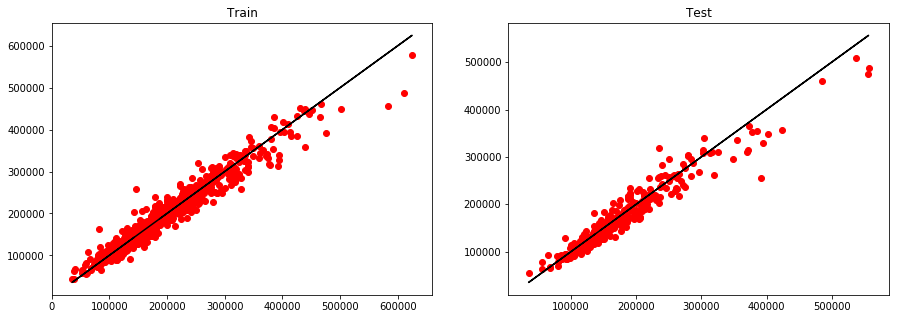

In [12]:
elastic = ElasticNet(alpha = 0.0007, l1_ratio = 0.1)
elastic.fit(X_train, np.log(y_train))
report_model(np.exp(elastic.predict(X_train)), np.exp(elastic.predict(X_test)))

         Train_RMSE  Test_RMSE
1          0.028746   0.069449
2          0.025318   0.169166
3          0.033295   0.134534
4          0.034307   0.096827
5          0.032243   0.096838
6          0.029925   0.091020
7          0.031933   0.118955
8          0.029694   0.091988
9          0.031507   0.161860
10         0.032049   0.116557
Average    0.031002   0.118657


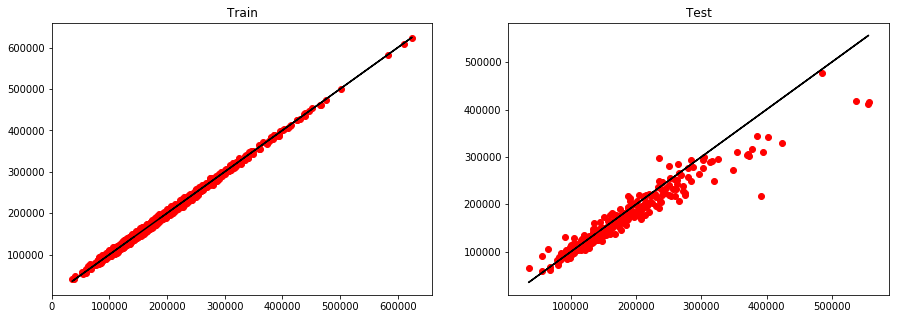

In [13]:
xg = xgb.XGBRegressor(colsample_bytree=0.8, gamma=0,
                             learning_rate=0.005, max_depth=4, 
                             n_estimators=6000, reg_lambda=0.0001,
                             subsample=0.5, silent=1,
                             random_state = 7, nthread = -1)
xg.fit(X_train, y_train)
report_model(xg.predict(X_train), xg.predict(X_test))

In [20]:
#no model has a dominating performance in testing, so it makes sense to average them to get better accuracy
def find_averaging_ratio(model1 = elastic, model2 = xg):
    min_error = 1
    min_ratio = (1, 0)
    for i in np.arange(0, 1, 0.01):
        av_predict = np.exp(model1.predict(X_test))*i + model2.predict(X_test)*(1-i)
        error = np.sqrt(mean_squared_error(np.log(y_test), np.log(av_predict)))
        if error < min_error:
            min_error = error
            min_ratio = i, 1-i
    print('Log squared error with best ratio: %f' % (min_error))
    print('Best ratio: ', min_ratio)
find_averaging_ratio()       

Log squared error with best ratio: 0.108739
Best ratio:  (0.63, 0.37)


In [424]:
# sub = pd.DataFrame({'Id': sub, \
#                    'SalePrice': np.exp(xg.predict(new_test))})
# sub.to_csv('xgboost_stacking.csv', index=False)